# Denoising Diffusion Probabilistic Models (DDPMs) with fastai
By Tanishq Abraham

In this notebook, we will implement [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), a seminal paper in the diffusion model literature.

A one-sentence summary: Train a denoising model conditioned on the amount of noise present in the image, and generate samples by iteratively denoising from pure noise to a final sample.

Let's get started with the implementation!

## Imports

Here are all our imports. The unet file is taken from [lucidrains' DDPM implementation](https://github.com/lucidrains/denoising-diffusion-pytorch) just to focus on implementing the training process rather than architectural details.

In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
from unet import Unet
from copy import deepcopy

## Dataloading

Let's load our data. We'll work with the famous MNIST dataset.

In [2]:
bs = 256 # batch size
size = 32 # image size

In [3]:
path = untar_data(URLs.MNIST)

We use the highly flexible DataBlock API in fastai to create our DataLoaders.

~~Note that we start with pure noise, generated with the obviously named `generate_noise` function.~~

In [4]:
path.ls()

(#3) [Path('/home/tcapelle/.fastai/data/mnist_png/testing'),Path('/home/tcapelle/.fastai/data/mnist_png/training'),Path('/home/tcapelle/.fastai/data/mnist_png/models')]

Let's use a labelled dataset and train a conditional model on the label

In [5]:
dblock = DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock()),
                   get_items = get_image_files,
                   get_y = lambda p: p.parent.name,
                   splitter = GrandparentSplitter("training", "testing"),
                   item_tfms=Resize(size), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5]), torch.tensor([0.5])))

In [6]:
dls = dblock.dataloaders(path, path=path, bs=bs)

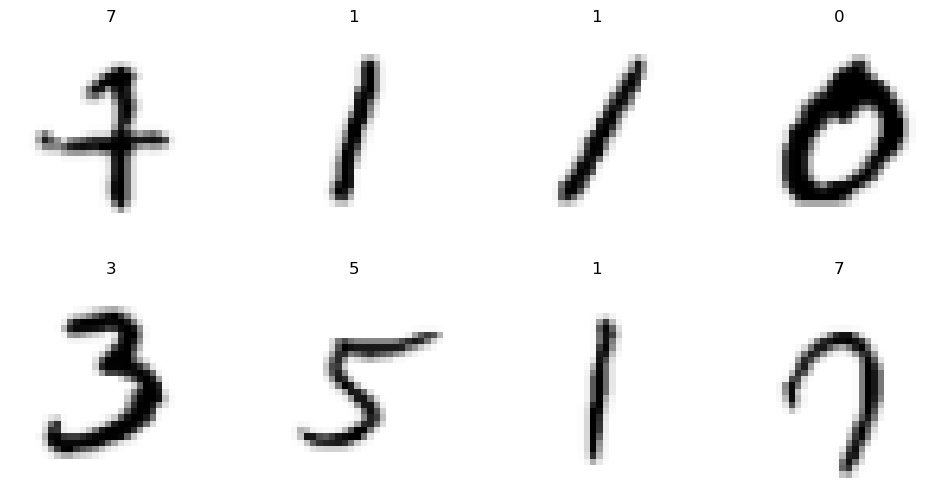

In [7]:
dls.show_batch(max_n=8)

## DDPM Training as a Callback

DDPM is trained quite simply in a few steps:
1. randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image to our model
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image


We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.

After training, we need to sample from this model. This is an iterative denoising process starting from pure noise. We simply keep removing noise predicted by the neural network, but we do it with an expected noise schedule that is reverse of what we saw during training. This is also done in our callback.



In [8]:
class ConditionalDDPMCallback(Callback):
    def __init__(self, n_steps, beta_min, beta_max, tensor_type=TensorImage):
        store_attr()

    def before_fit(self):
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps).to(self.dls.device) # variance schedule, linearly increased with timestep
        self.alpha = 1. - self.beta 
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = torch.sqrt(self.beta)


    def before_batch_training(self):
        x0 = self.xb[0] # original images, x_0
        eps = self.tensor_type(torch.randn(x0.shape, device=x0.device)) # noise, x_T
        
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long) # select random timesteps
        alpha_bar_t = self.alpha_bar[t].reshape(-1, 1, 1, 1)
        
        xt =  torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*eps #noisify the image
        self.learn.xb = (xt, t, self.yb[0]) # input to our model is noisy image and timestep
        self.learn.yb = (eps,) # ground truth is the noise 


    def before_batch_sampling(self):
        xt = self.tensor_type(self.xb[0])
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
            z = torch.randn(xt.shape, device=xt.device) if t > 0 else torch.zeros(xt.shape, device=xt.device)
            alpha_t = self.alpha[t] # get noise level at current timestep
            alpha_bar_t = self.alpha_bar[t]
            sigma_t = self.sigma[t]
            xt = 1/torch.sqrt(alpha_t) * (xt - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * self.model(xt, t_batch))  + sigma_t*z # predict x_(t-1) in accordance to Algorithm 2 in paper
        self.learn.pred = (xt,)
        raise CancelBatchException

    def before_batch(self):
        if not hasattr(self, 'gather_preds'): self.before_batch_training()
        else: self.before_batch_sampling()


In [43]:
@delegates(Unet)
class ConditionalUnet(Unet):
    def __init__(self, dim, num_classes=None, **kwargs):
        super().__init__(dim=dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, dim * 4)
    
    def forward(self, x, time, label=None):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        if label is not None:
            t += self.label_emb(label)
            
        return super().forward_blocks(x, t, r)

Let's now initialize our model:

In [44]:
model = ConditionalUnet(dim=32, channels=1, num_classes=10).cuda()

Now we can create a fastai Learner with our DataLoaders, Callback (with the appropriate number of timesteps and noise schedule) and the simple MSE loss that we use to train DDPM.

In [48]:
ddpm_learner = Learner(dls, model, 
                       cbs=[ConditionalDDPMCallback(n_steps=1000, beta_min=0.0001, beta_max=0.02, tensor_type=TensorImageBW)], 
                       loss_func=nn.MSELoss()).to_fp16()

Let's use fastai's amazing LR finder to select a good LR for training:

In [ ]:
ddpm_learner.lr_find()

And now let's train with one-cycle LR schedule:

In [43]:
ddpm_learner.fit_one_cycle(3,3e-4)

epoch,train_loss,valid_loss,time
0,0.080676,0.054853,00:42
1,0.033603,0.031451,00:42
2,0.028530,0.027913,00:42


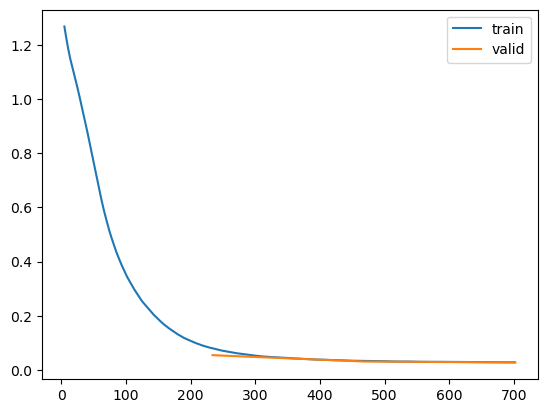

In [44]:
ddpm_learner.recorder.plot_loss()

## Sample generation

Since we implemented sampling in the Callback, we simply can call fastai's built-in `get_preds` function to get our predictions.

In [45]:
preds = ddpm_learner.get_preds()

<AxesSubplot:>

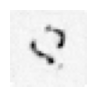

In [30]:
preds[0][0].show()

Awesome, we got a simple MNIST digit!

Another useful thing to check is the prediction of the completely denoised image at some timestep. Our sampling takes our prediction of noise in the image but takes only a fraction of it to remove from the noisy image during the iterative process. But we can also try to see the full denoising prediction by fully subtracting out the prediction. Of course, at higher noise levels this will be inaccurate, but at lower noise levels it should be quite accurate.

In [16]:
eps = TensorImageBW(xb)
x0 = yb # original images
batch_size = x0.shape[0]
with torch.no_grad():
    t = torch.randint(0, ddpm_learner.ddpm.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
    alpha_bar_t = ddpm_learner.ddpm.alpha_bar[t].reshape(-1, 1, 1, 1)
    xt =  torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*eps # noisy images
    x0hat = (xt - torch.sqrt(1-alpha_bar_t)*ddpm_learner.model(xt,t))/torch.sqrt(alpha_bar_t) # predicted denoised images

Timestep 73 is closer to 0 so less noisy but noise is still visible.

In [18]:
np.where((t==73).cpu())

(array([5]),)

Now we can see the original clean image (x0), the noisy image (xt), and the model's attempt to remove the noise (x0hat)

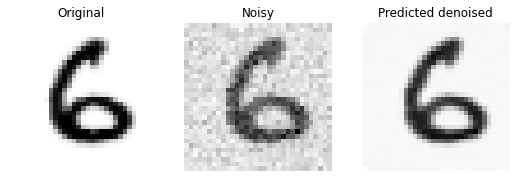

In [19]:
ctxs = get_grid(3,1,3)
ax1 = x0[5].show(ctx=ctxs[0], title='Original')
ax2 = xt[5].show(ctx=ctxs[1], title='Noisy')
ax3 = x0hat[5].show(ctx=ctxs[2], title='Predicted denoised')